#**Proyek Sistem Rekomendasi: Books**


Buku telah menjadi salah satu sumber informasi dan hiburan paling penting bagi manusia selama berabad-abad. Namun, dengan semakin banyaknya judul buku yang diterbitkan setiap tahun, pembaca sering kali kesulitan menemukan buku yang sesuai dengan minat mereka. Menurut data dari International Publishers Association, lebih dari 2 juta judul buku baru diterbitkan secara global setiap tahunnya [1]. Hal ini menciptakan fenomena yang dikenal sebagai "paradox of choice" atau paradoks pilihan, di mana terlalu banyak opsi justru membuat konsumen kesulitan untuk membuat keputusan [2].

Sistem rekomendasi buku hadir sebagai solusi untuk masalah ini. Dengan memanfaatkan teknik machine learning, sistem rekomendasi dapat menganalisis data karakteristik buku dan preferensi pengguna untuk memberikan rekomendasi yang lebih personal dan relevan. Penelitian oleh Adomavicius dan Tuzhilin menunjukkan bahwa sistem rekomendasi yang efektif dapat meningkatkan kepuasan pengguna hingga 27% dan meningkatkan peluang transaksi hingga 35% [3].

Dalam proyek ini, saya mengembangkan sistem rekomendasi buku menggunakan dataset Kaggle yang berisi informasi detail tentang ribuan buku. Dengan memadukan pendekatan content-based filtering dan collaborative filtering, proyek ini bertujuan untuk memberikan rekomendasi buku yang akurat dan personal kepada pengguna berdasarkan kesamaan konten buku dan pola peringkat dari pengguna lain.

## **Import Library**

Di tahap awal ini, seluruh library yang diperlukan untuk proses analisis dan pengembangan sistem rekomendasi berbasis dataset buku diimpor terlebih dahulu. Langkah ini penting untuk memastikan semua fungsi yang dibutuhkan  mulai dari praproses data, analisis, visualisasi, hingga pembuatan model rekomendasi sudah siap digunakan sejak awal.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

## Load Dataset

Membaca file CSV dan Menampilkan data 5 teratas dan terbawah

In [2]:
df = pd.read_csv('/content/Books.csv')

df.head() # menampilkan 5 data teratas

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,userId
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,1
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,2
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,3
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,4
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,5


## **Data Understanding**

Pada tahap ini dilakukan proses pemahaman awal terhadap dataset yang akan digunakan dalam sistem rekomendasi buku. Tujuannya adalah untuk mengetahui struktur data, jenis informasi yang tersedia, serta mengecek adanya data yang hilang (missing values). Proses ini penting agar kita bisa menentukan langkah pembersihan dan transformasi data yang sesuai sebelum membangun model.

In [3]:
# Tampilkan informasi data yang bernilai null
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 isbn13               0
isbn10               0
title                0
subtitle          4429
authors             72
categories          99
thumbnail          329
description        262
published_year       6
average_rating      43
num_pages           43
ratings_count       43
userId               0
dtype: int64


## **EDA**

Langkah ini bertujuan untuk memahami struktur data, ringkasan statistik, distribusi nilai, serta deteksi awal terhadap duplikasi dan nilai kosong. Ini penting untuk memastikan kualitas data sebelum modeling. EDA sangat penting dalam sistem rekomendasi karena dapat mengungkapkan insight penting yang dapat memengaruhi pemodelan, seperti distribusi rating, popularitas penulis, dan kelengkapan informasi buku.

In [4]:
df.info() # Menampilkan informasi data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
 12  userId          6810 non-null   int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 691.8+ KB


In [5]:
df.describe() # Memberikan statistik deskriptif

,isbn13,published_year,average_rating,num_pages,ratings_count,userId
count,6.810000e+03,6804.000000,6767.000000,6767.000000,6.767000e+03,6810.000000
mean,9.780677e+12,1998.630364,3.933284,348.181026,2.106910e+04,3405.500000
std,6.068911e+08,10.484257,0.331352,242.376783,1.376207e+05,1966.021999
min,9.780002e+12,1853.000000,0.000000,0.000000,0.000000e+00,1.000000
25%,9.780330e+12,1996.000000,3.770000,208.000000,1.590000e+02,1703.250000
50%,9.780553e+12,2002.000000,3.960000,304.000000,1.018000e+03,3405.500000
75%,9.780810e+12,2005.000000,4.130000,420.000000,5.992500e+03,5107.750000
max,9.789042e+12,2019.000000,5.000000,3342.000000,5.629932e+06,6810.000000


In [6]:
# Menyajikan jumlah total data, jumlah nilai valid (Non-NaN), dan nilai kosong (NaN) untuk setiap kolom dalam bentuk tabel.
print(pd.DataFrame({'Total Data': df.shape[0], 'Non-NaN': df.count(), 'NaN': df.isna().sum()}))


                Total Data  Non-NaN   NaN
isbn13                6810     6810     0
isbn10                6810     6810     0
title                 6810     6810     0
subtitle              6810     2381  4429
authors               6810     6738    72
categories            6810     6711    99
thumbnail             6810     6481   329
description           6810     6548   262
published_year        6810     6804     6
average_rating        6810     6767    43
num_pages             6810     6767    43
ratings_count         6810     6767    43
userId                6810     6810     0


In [7]:
# Fungsi bantu plotting
def plot_hist(data, title, xlabel, bins=30, log=False):
    plt.figure(figsize=(10,5))
    sns.histplot(data.dropna(), bins=bins, log_scale=log)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

def plot_box(data, title):
    plt.figure(figsize=(10,2))
    sns.boxplot(x=data.dropna())
    plt.title(title)
    plt.show()

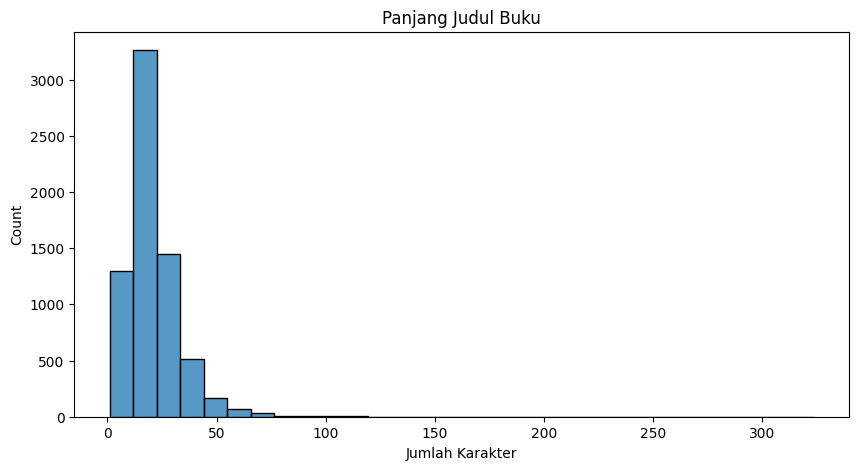

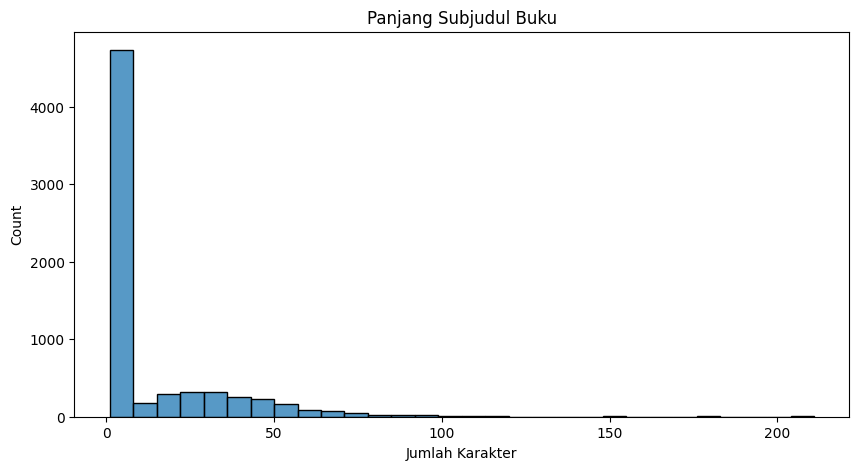

In [8]:
# --- Title / Subtitle ---
df['title_length'] = df['title'].astype(str).apply(len)
plot_hist(df['title_length'], "Panjang Judul Buku", "Jumlah Karakter")

if df['subtitle'].notnull().sum() > 0:
    df['subtitle_length'] = df['subtitle'].astype(str).apply(len)
    plot_hist(df['subtitle_length'], "Panjang Subjudul Buku", "Jumlah Karakter")

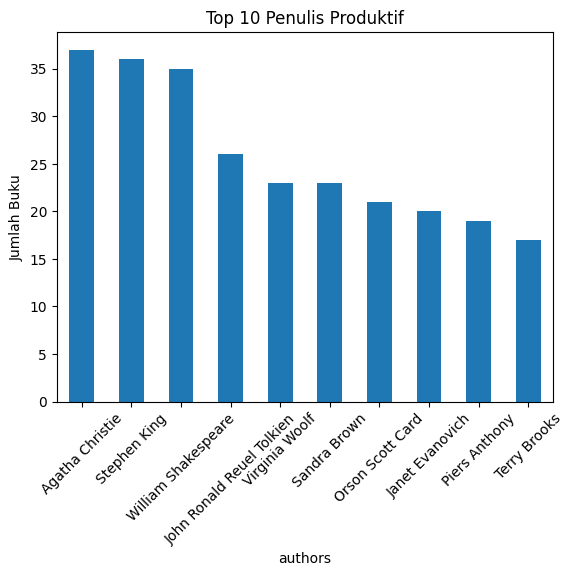

In [9]:
# --- Authors ---
top_authors = df['authors'].value_counts().head(10)
top_authors.plot(kind='bar', title='Top 10 Penulis Produktif')
plt.ylabel('Jumlah Buku')
plt.xticks(rotation=45)
plt.show()

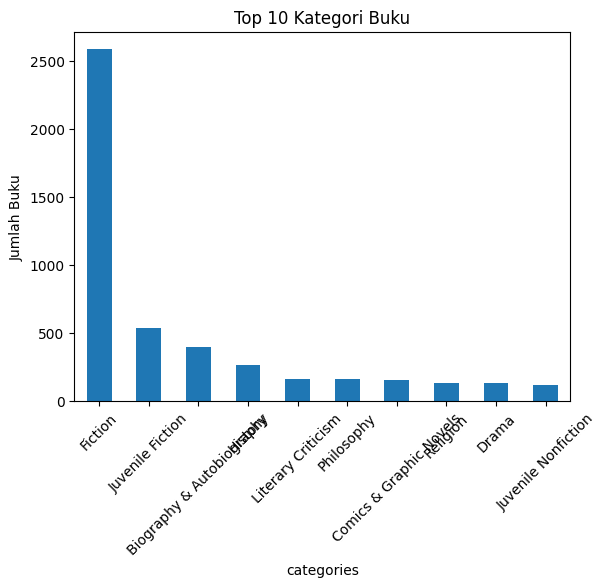

In [10]:
# --- Categories ---
top_categories = df['categories'].value_counts().head(10)
top_categories.plot(kind='bar', title='Top 10 Kategori Buku')
plt.ylabel('Jumlah Buku')
plt.xticks(rotation=45)
plt.show()

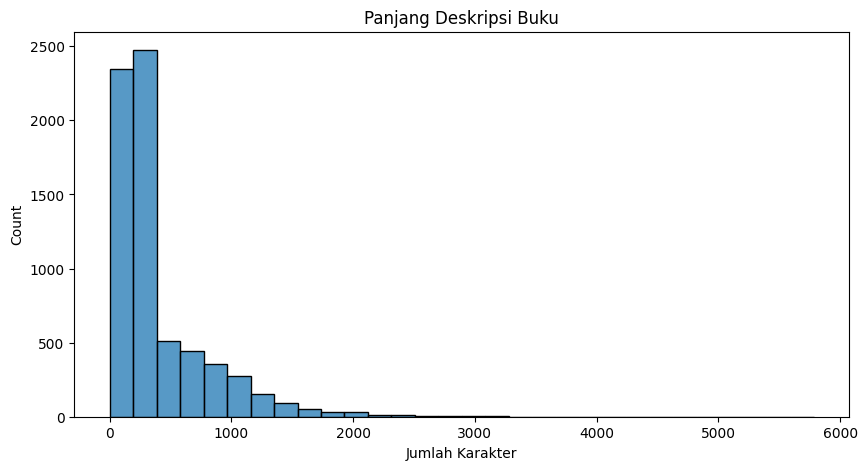

In [11]:
# --- Description length ---
df['desc_length'] = df['description'].astype(str).apply(len)
plot_hist(df['desc_length'], "Panjang Deskripsi Buku", "Jumlah Karakter")

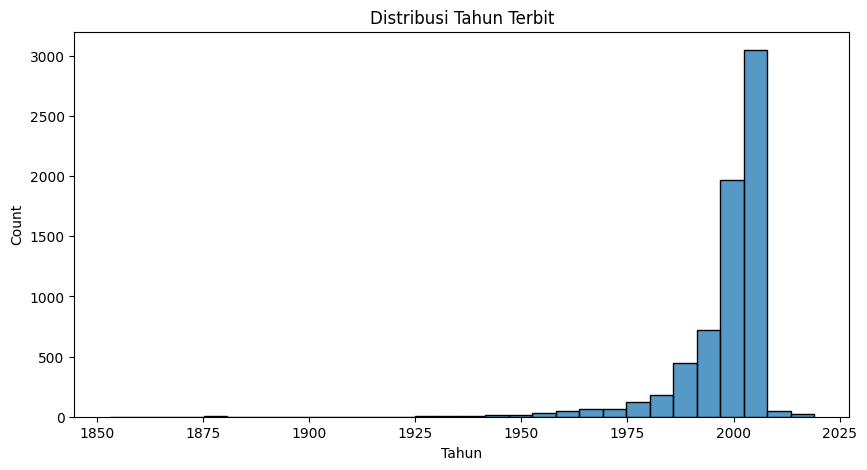

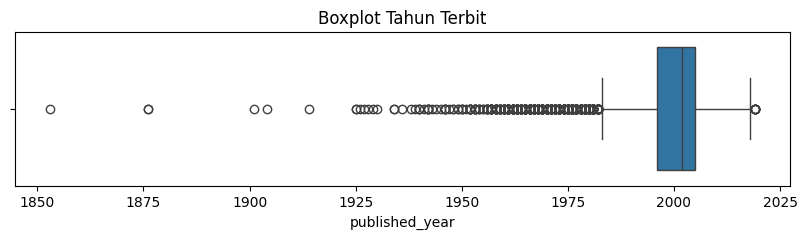

In [12]:
# --- Published Year ---
plot_hist(df['published_year'], "Distribusi Tahun Terbit", "Tahun")
plot_box(df['published_year'], "Boxplot Tahun Terbit")

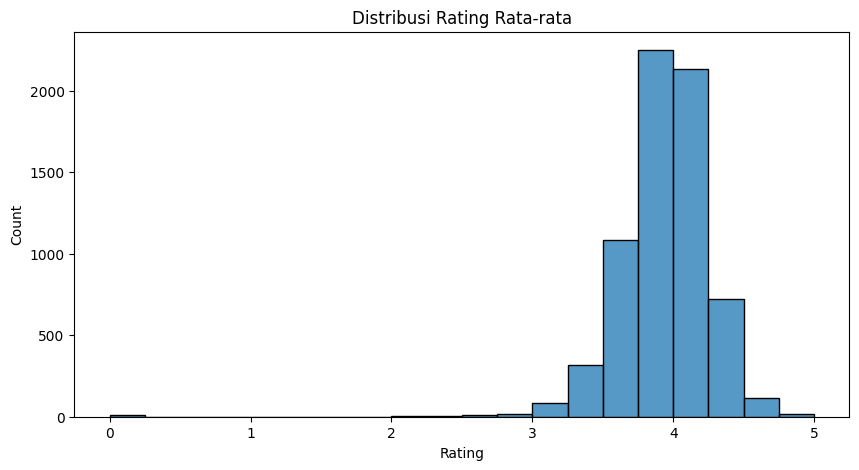

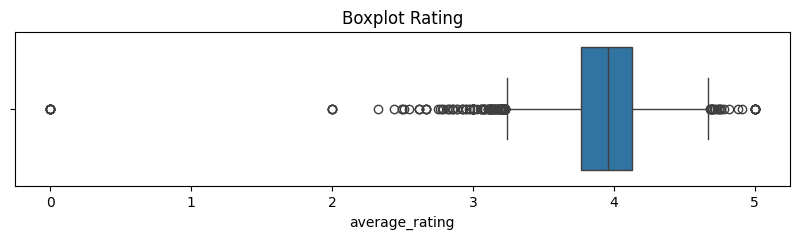

In [13]:
# --- Average Rating ---
plot_hist(df['average_rating'], "Distribusi Rating Rata-rata", "Rating", bins=20)
plot_box(df['average_rating'], "Boxplot Rating")

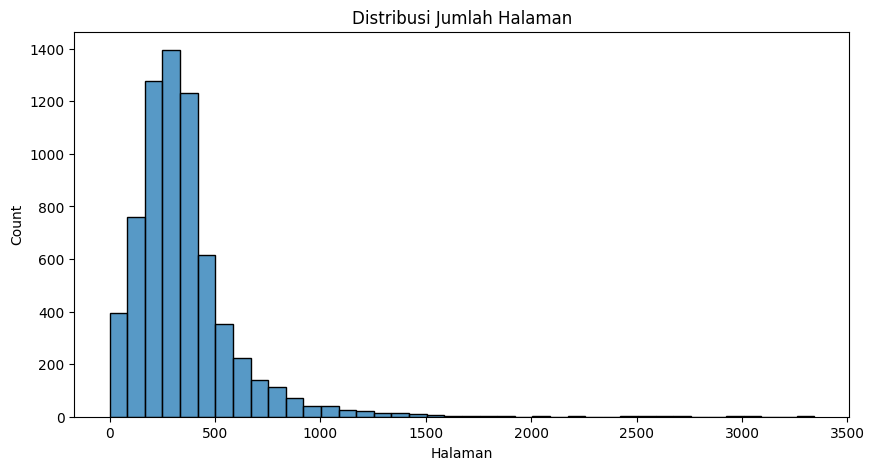

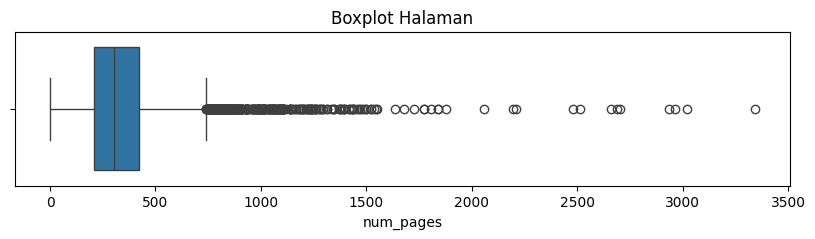

In [14]:
# --- Num Pages ---
plot_hist(df['num_pages'], "Distribusi Jumlah Halaman", "Halaman", bins=40)
plot_box(df['num_pages'], "Boxplot Halaman")

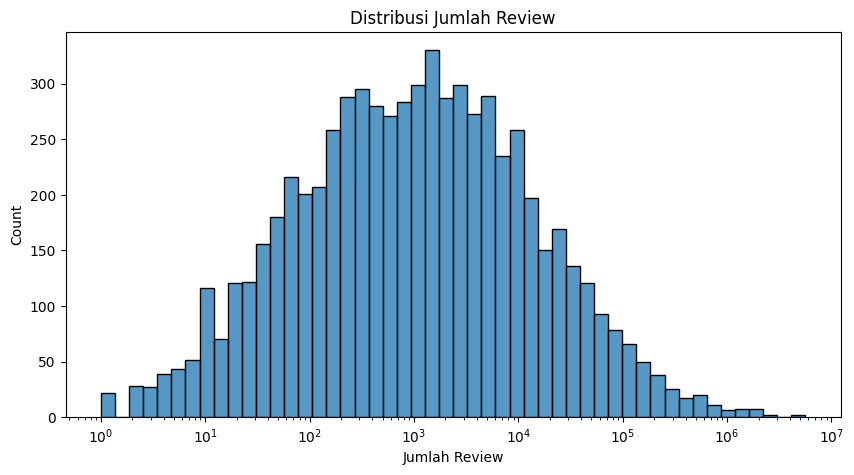

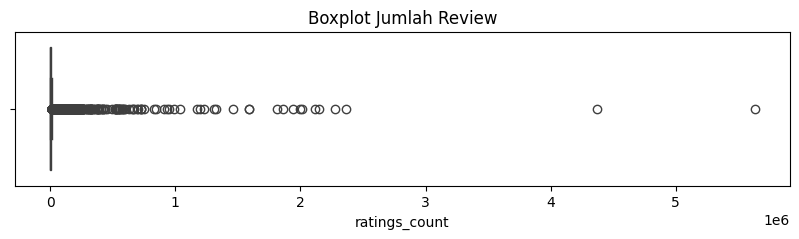

In [15]:
# --- Ratings Count ---
plot_hist(df['ratings_count'], "Distribusi Jumlah Review", "Jumlah Review", bins=50, log=True)
plot_box(df['ratings_count'], "Boxplot Jumlah Review")

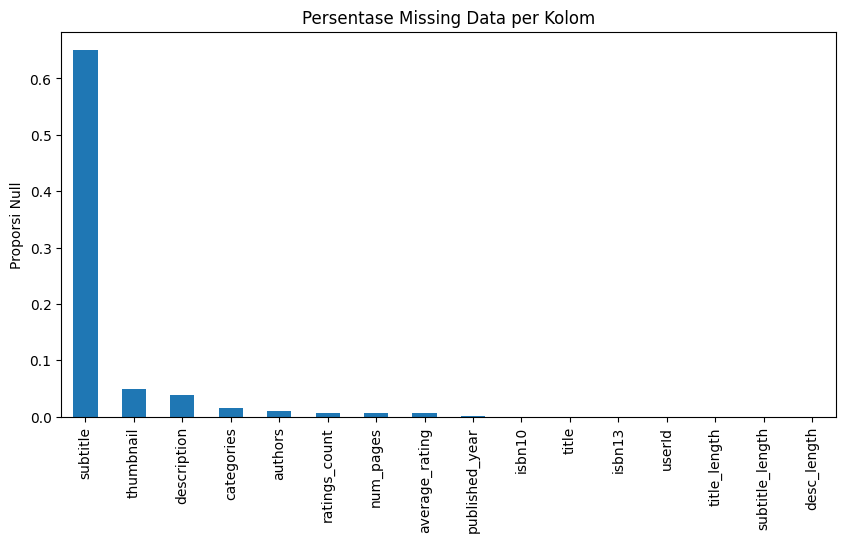

In [16]:
# --- Missing data visualisasi ---
plt.figure(figsize=(10,5))
df.isnull().mean().sort_values(ascending=False).plot(kind='bar')
plt.title("Persentase Missing Data per Kolom")
plt.ylabel("Proporsi Null")
plt.show()

## **Data Preparation**

Tahap ini berfokus pada pembuatan fitur utama yang akan digunakan dalam sistem rekomendasi berbasis Content-Based Filtering. Pendekatan ini merekomendasikan buku dengan cara membandingkan kesamaan kontennya — dalam hal ini berdasarkan teks seperti judul, penulis, kategori, dan deskripsi buku.

#### Handle Missing Values dan Normalisasi

In [17]:
# a. Handle missing values
for col in ['subtitle', 'authors', 'categories', 'description']:
    df[col] = df[col].fillna('')

# b. Text normalization (simple lowercase)
for col in ['title', 'subtitle', 'authors', 'categories', 'description']:
    df[col] = df[col].str.lower()


#### Gabungkan Fitur Teks

In [18]:
# c. Gabungkan fitur teks
df['features'] = (
    df['title'] + ' ' +
    df['subtitle'] + ' ' +
    df['authors'] + ' ' +
    df['categories'] + ' ' +
    df['description']
)


#### TF-IDF Vectorization dan Similarity

In [19]:
# d. Vectorize
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['features'])

# e. Compute similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


#### Lookup Dictionary

In [20]:
# f. Build lookup
title_to_idx = pd.Series(df.index, index=df['title']).drop_duplicates()


#### Pivot Table dan Train-Test Split

In [21]:
# g. Buat pivot table (user-item)
pivot = df.pivot_table(
    index="userId",
    columns="isbn13",
    values="average_rating",
    fill_value=0
)

# e. Split data: sebagian user untuk test set
trainset, testset = train_test_split(
    pivot,
    test_size=0.2,
    random_state=42
)

## **Model Development dengan Content-Based Filtering**

Pada tahap ini dikembangkan sebuah model rekomendasi berbasis Content-Based Filtering, yaitu sistem yang merekomendasikan buku-buku yang memiliki konten serupa dengan buku yang dipilih pengguna. Model ini bekerja dengan membandingkan representasi teks (judul, deskripsi, kategori, penulis) menggunakan cosine similarity.

In [22]:
def recommend_content(title, top_n=5):
    title = title.lower()
    if title not in title_to_idx:
        raise ValueError(f"'{{title}}' not ditemukan di dataset")
    idx = title_to_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    book_indices = [i[0] for i in sim_scores]
    return df[['title', 'authors', 'average_rating']].iloc[book_indices]

# Demo content-based
try:
    sample = df['title'].iloc[0]
    print("Contoh rekomendasi (Content-Based) untuk:", sample)
    print(recommend_content(sample, top_n=5))
except Exception as e:
    print(e)

Contoh rekomendasi (Content-Based) untuk: gilead
                             title             authors  average_rating
918     go tell it on the mountain       james baldwin            4.01
5295  four baboons adoring the sun          john guare            4.00
2248         children of the alley        najīb maḥfūẓ            4.10
6071            laguna, i love you           john weld            0.00
744      the deep end of the ocean  jacquelyn mitchard            3.86


## **Model Development dengan Collaborative Filtering**

Tahap ini membangun sistem rekomendasi buku berdasarkan preferensi pengguna lain menggunakan pendekatan Collaborative Filtering. Berbeda dengan Content-Based yang fokus pada fitur buku, Collaborative Filtering memanfaatkan pola rating dari banyak pengguna untuk memperkirakan minat pengguna tertentu terhadap buku yang belum mereka baca.



#### Latent Factor Model: Truncated SVD

In [23]:
# 1. Latent factor model (Truncated SVD)
svd = TruncatedSVD(n_components=20, random_state=42)
svd.fit(trainset)


TruncatedSVD(n_components=20, random_state=42)

#### Hitung RMSE dari Rekonstruksi Test Set

In [24]:
# 2. Hitung RMSE
latent_test    = svd.transform(testset)
testset_approx = np.dot(latent_test, svd.components_)

rmse = np.sqrt(mean_squared_error(
    testset.values.flatten(),
    testset_approx.flatten()
))
print(f"▶ RMSE (TruncatedSVD) : {rmse:.4f}\n")


▶ RMSE (TruncatedSVD) : 0.0479



#### Fungsi Rekomendasi Buku per User

In [25]:
# 3. Fungsi rekomendasi yang mengembalikan DataFrame
def recommend_books_user(user_id, n=5):
    if user_id not in pivot.index:
        raise ValueError(f"User ID {user_id} tidak ditemukan di dataset.")

    # Representasi laten user
    latent_user = svd.transform(pivot.loc[[user_id]])
    pred_ratings = np.dot(latent_user, svd.components_).flatten()

    # Series prediksi rating
    pred_series = pd.Series(pred_ratings, index=pivot.columns)

    # Filter item belum di-rating (rating = 0)
    unrated = pred_series[pivot.loc[user_id] == 0]

    # Ambil top-n berdasarkan prediksi
    top_n = unrated.nlargest(n)

    # Bangun DataFrame rekomendasi
    rec_df = top_n.reset_index()
    rec_df.columns = ['isbn13', 'PredictedRating']

    # Map isbn ke judul buku
    title_map = df.set_index('isbn13')['title'].to_dict()
    rec_df['Title'] = rec_df['isbn13'].map(title_map).fillna(rec_df['isbn13'])

    # Atur ulang kolom
    rec_df = rec_df[['Title', 'PredictedRating']]
    rec_df['PredictedRating'] = rec_df['PredictedRating'].round(2)

    return rec_df


#### Contoh Pemanggilan Fungsi Rekomendasi

In [26]:
# 4. Contoh pemanggilan
user_test = 1
try:
    print(f"▶ Rekomendasi untuk userId {user_test}:\n")
    print(recommend_books_user(user_test, n=5).to_string(index=False))
except ValueError as e:
    print("⚠", e)


▶ Rekomendasi untuk userId 1:

                          Title  PredictedRating
              fanning the flame             0.02
   the diamond color meditation             0.01
the feynman lectures on physics             0.01
                     empire 2.0             0.01
        the secretary of dreams             0.01


## **Evaluasi**

Pada tahap ini, kita mengukur performa kedua metode rekomendasi yang telah dikembangkan, yaitu Content-Based Filtering dan Collaborative Filtering, menggunakan metrik yang sesuai.

In [31]:
print("\n▶ Evaluasi Content-Based Filtering")

# Precision@K (Proxy via Cosine Similarity)
def precision_at_k(sim_scores, k=5, threshold=0.5):
    top_k = np.sort(sim_scores)[-k:]  # ambil k skor tertinggi
    relevant = top_k[top_k >= threshold]
    precision = len(relevant) / k
    return precision

# Ambil cosine similarity untuk satu buku contoh
book_index = 0  # indeks buku yang akan dijadikan referensi
sim_scores = cosine_sim[book_index]

# Hitung Precision@5
precision = precision_at_k(sim_scores, k=5, threshold=0.5)
print(f"Precision@5 (Cosine Similarity ≥ 0.5): {precision:.2f}")

# Relevance Score (rerata similarity top-K)
top_k_idx = sim_scores.argsort()[-5:][::-1]  # indeks top-5
relevance_scores = sim_scores[top_k_idx]
avg_relevance = np.mean(relevance_scores)
print(f"Rata-rata Relevance Score Top-5 Rekomendasi: {avg_relevance:.2f}")

# -------------------------------------------
# 2. Evaluasi Collaborative Filtering
# -------------------------------------------

print("\n▶ Evaluasi Collaborative Filtering")

# Asumsikan `trainset`, `testset`, dan `svd` sudah tersedia dari langkah sebelumnya
latent_test = svd.transform(testset)
testset_approx = np.dot(latent_test, svd.components_)
rmse = np.sqrt(mean_squared_error(testset.values.flatten(), testset_approx.flatten()))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")



▶ Evaluasi Content-Based Filtering
Precision@5 (Cosine Similarity ≥ 0.5): 0.20
Rata-rata Relevance Score Top-5 Rekomendasi: 0.36

▶ Evaluasi Collaborative Filtering
Root Mean Square Error (RMSE): 0.0479
